### Challenge 4 (8 points) -- Advanced

* Use the data file "challenge3.gwf" with channels "H1:CHALLENGE3" and "L1:CHALLENGE3".
* These are real LIGO data from O2, though we've adjusted the time labels and 
  added some simulated signals.
* Any simulated signals have been added to both the H1 and L1 data
* All simulated signals have 0 spin and m1=m2, with m1 somewhere in the range 10-50 solar masses

1. Identify as many signals as you can.  Watch out!  These are real data, and so glitches may be
present.  Any correct detection is +1 point but any false alarms will count -1 point 
against your score.  For each signal you find, list:

 * The merger time
 * The SNR
 * Your estimate of the component masses

2. Identify as many glitches as you can.  Make a spectrogram of each one.

3. For each simulated BBH you found, use bilby to compute a posterior
   distribution for the mass. You can fix the spin and mass ratio to make
   this run faster.
   

# Question 1:

We are going to repeat the same analysis as in challenge 3 but for several masses between 10 and 50 solar masses. Therefore, we define `import_data`, `compute_psd`, `compute_waveform`, `compute_snr`, `plot_qtransform`, and `plot_check_chisq` functions.

Steps : 
- Import librairies and data
- Compute the psd
- Compute the waveforms for each mass
- Compute the SNR
- Look at the peak in the SNR

In [4]:
# import libraries
import pylab
import numpy as np
import matplotlib.pyplot as plt
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc.vetoes import power_chisq
from scipy.signal import find_peaks 
from astropy.table import QTable

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [5]:
# define useful functions

def import_data(file, channels, low_frequency_cutoff=20.):
    '''
    Function to import .gwf data files
        file: str
        channels: list
    '''
    data_raw = read_frame(file, channels=channels)
    data = data_raw
    
    for i in range(len(data_raw)):
        data[i] = highpass(data_raw[i], low_frequency_cutoff)
        data[i] = data[i].crop(2,2)

    return data
    

def compute_psd(data, sample_time=4., low_frequency_cutoff=20.):
    '''
    Function to compute the PSD 
        data_raw: 
        sample_time: float
        low_frequency_cutoff: float
    '''
        
    # Estimate the power spectral density (2.2 method)
    psd = data.psd(sample_time)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner
    psd = interpolate(psd, data.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 15 Hz, and will have low values
    # below this we need to inform the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(sample_time * data.sample_rate), low_frequency_cutoff=low_frequency_cutoff)
    
    return psd


def compute_waveform(mass1, mass2, delta_t, length, spin1z=0, spin2z=0):
    '''
    Returns the waveform produced by two masses with m1=m2
    '''
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt", # useful when the masses are above 4 solar masses
                             mass1=mass1,
                             mass2=mass2,
                             spin1z=spin1z,
                             spin2z=spin2z,
                             delta_t=delta_t,
                             f_lower=20)
    hp.resize(length)
    hp = hp.cyclic_time_shift(hp.start_time)
        
    return hp


def compute_snr(waveform, data, psd,  plot=False):
    '''
    Function to compute the SNR 
    '''
    snr = matched_filter(waveform, data, psd=psd, low_frequency_cutoff=20)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr = snr.crop(4 + 4, 4)

    # Why are we taking an abs() here?
    # The `matched_filter` function actually returns a 'complex' SNR.
    # What that means is that the real portion correponds to the SNR
    # associated with directly filtering the template with the data.
    # The imaginary portion corresponds to filtering with a template that
    # is 90 degrees out of phase. Since the phase of a signal may be 
    # anything, we choose to maximize over the phase of the signal.
    if plot:
        pylab.figure(figsize=[10, 4])
        pylab.plot(snr.sample_times, abs(snr))
        pylab.ylabel('Signal-to-noise')
        pylab.xlabel('Time (s)')
        pylab.show()

    return snr   



                
def plot_qtransform(data, t0, dt, figtitle='Q_transform plot'):
    '''
    Plot qtransform
        data:
        t0: float
        dt: float
    '''
    start  = t0 - dt
    end    = t0 + dt
    
    fig, ax = plt.subplots(2,1, figsize=(10,4))
    fig.suptitle(figtitle)
    
    for j in [0,1]:
        dt     = data[j].get_delta_t()
        signal = data[j].time_slice(start, end, mode='floor')
        t, f, p = signal.qtransform(delta_t=dt, logfsteps=100, qrange=(10, 11), frange=(20, 512))
        ax[j].pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
        ax[j].set_yscale('log')
        ax[j].set_xlabel('Time (s)')
        ax[j].set_ylabel('Frequency (Hz)')
    plt.show()

    
def plot_check_chisq(data, t0, dt, figtitle=''):
    '''
    Plot chisq vs. time
        data:
        t0: float
        dt: float
    '''
    label = ['H','L']
    start  = t0 - dt
    end    = t0 + dt
    
    data_slice = {}
    psd = {}
    for i in range(2):
        data_slice[i] = data[i].time_slice(start, end, mode='floor')
        psd[i] = compute_psd(data_slice[i])

    waveform = compute_waveform(50, 50, data_raw[0].delta_t, len(data_slice[0]))

    snr={}
    for i in range(2):
      snr[i] = compute_snr(waveform, data_slice[i], psd[i],  plot=False)
      snr[i]= np.abs(snr[i].numpy())

    chisq = {}
    for i in range(2):
        # The number of bins to use. In principle, this choice is arbitrary. In practice,
        # this is empirically tuned.
        nbins = 26
        chisq[i] = power_chisq(waveform, data_slice[i], nbins, psd[i], low_frequency_cutoff=20.0)
        chisq[i] = chisq[i].crop(5, 4)

        dof = nbins * 2 - 2
        chisq[i] /= dof

    for i in range(2):
        pylab.plot(chisq[i].sample_times, chisq[i], label=label[i])

    pylab.legend()
    pylab.grid()
    pylab.xlim(t0-0.15, t0+0.15)
    pylab.ylabel('$chi^2_r$')
    pylab.show()

In [19]:
# import data
data_raw       = import_data('challenge3.gwf', ['H1:CHALLENGE3','L1:CHALLENGE3'])
detector_names = ['H','L']

In [4]:
# Compute PSDs
psd = [compute_psd(data_raw[0]), compute_psd(data_raw[1])]

In [24]:
# Some definitions
N_masses = 41
masses = np.linspace(10,50,N_masses)
print("Mass grid:", masses)

Mass grid: [10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.
 46. 47. 48. 49. 50.]


# Remarks : 

We chose a threshold on the SNR :  above it we can claim a detection and below we consider that it's just noise. 

1. In PyCBC's match filtering method the threshold used is 8, here we define a threshold thanks to the standard deviation of the SNR : 11*np.std(abs(snr)) which is around 8.
2. We also assumed that the events don't overlap and last at most 1min, so we looked for the peaks in windows of 60s in the SNR vs time arrays. 
3. We create after that a table with all the peaks we found. Be careful : these are not all signal, obviously ! First of all the triggers are unclustered here so we have a lot of triggers at almoste the same time.
We used the find_peaks function from scipy to solve this problem.

In [ ]:
detections = QTable(names=['time', 'SNR', 'mass', 'detector'], dtype=['float','float','float', 'U2'])

# Analysis for the entire mass grid 
for m in masses:
    print("> Analyzing mass", m)
    

    ################################
    # Analysis of LIGO Handford (0), Livingston (1) data
    #
    for j in [0,1]:
        Ndata    = len(data_raw[j])
        waveform = compute_waveform(m, m, data_raw[j].delta_t, Ndata)
        snr      = compute_snr(waveform, data_raw[j], psd[j],  plot=False)
        
        # Find SNR peaks
        peaks_heigth   = 11*np.std(abs(snr))
        peaks_distance = 60*int(snr.sample_rate)
        peak_idx, snrp = find_peaks(np.abs(snr.numpy()), height = peaks_heigth, distance = peaks_distance)
        snrp           = np.array(list(snrp.values())).flatten()
        timep          = np.array(snr.sample_times[peak_idx])

        elif find_peaks_fcn == 'raw':
            snrp, timep, timep_err = find_peaks(tempsnr, snr_threshold=10*np.std(abs(snr)) )
    
        # Add the detections to dataframe
        for k in range(len(snrp)):
#             print("... {:.2f}  {:.2f}  {:.2f}".format(timep[k], snrp[k], m, detector_names[j]))
            detections.add_row([timep[k], snrp[k], m, detector_names[j]])  
    

In [26]:
# Save preliminary detection file
detections.write('./events_raw.txt', format='ascii')

# Table with detections

It appears that we had mass distribution for each peak, in other words, for one particular time we could have several masses estimations. To take the good masses approximations, we produced plots of the mass distributions for each of the 9 peaks we found and we decided to take the masses associated to the max(SNR). This leads to the final table where we can find 5 signals and 2 blip glitches.

We claim directly a detection when we can see the peak in both detector (H1 & L1) and when we deal with a single detector peak we computed the chi^2 and produced q_transform plots. When the chi^2 is bigger than 1 we assume that it's a glitch.

In [7]:
# Load detection file
detections = QTable.read('./events_raw.txt', format='ascii').group_by('detector')
detections.sort('time')

maskH = detections['detector'] == 'H'
maskL = detections['detector'] == 'L'
detH  = detections[maskH]
detL  = detections[maskL]

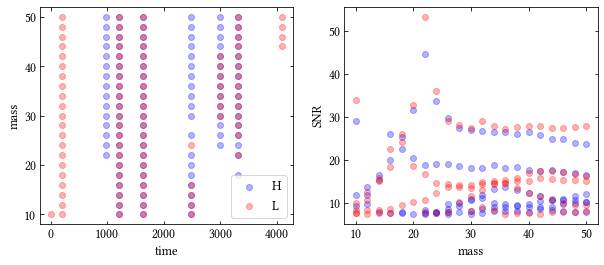

In [8]:
# Events identified from the exploration of the mass vs. time & SNR vs. mass plots

t_lo, t_up = 0, 4500
#
# t_lo, t_up = 0, 20       #- nothing - L: 7.6929965
# t_lo, t_up = 100, 300    #- blip - L: 17.513155
# t_lo, t_up = 800, 1000   #- ripped blip - H: 12.015228
# t_lo, t_up = 1100, 1500  #- chirp - H, L: 44.5408, 53.27839
# t_lo, t_up = 1500, 2000  #- chirp - H, L: 26.00237, 25.940258
# t_lo, t_up = 2400, 2600  #- chirp - H, L: 29.00907, 33.88981
# t_lo, t_up = 2800, 3000  #- chirp? - H, L: 11.072669, 9.104351
# t_lo, t_up = 3300, 3330  #- chirp - H, L: 13.667905, 14.770378
# t_lo, t_up = 4000, 4200  #- noise - L: 8.124456

windowH = (detH['time']>t_lo)&(detH['time']<t_up)
windowL = (detL['time']>t_lo)&(detL['time']<t_up)

timeH, timeL = detH['time'][windowH],detL['time'][windowL]
massH, massL = detH['mass'][windowH],detL['mass'][windowL]
snrH , snrL  = detH['SNR'][windowH],detL['SNR'][windowL]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(timeH,massH,alpha=.3,label='H', color='b')
ax[0].scatter(timeL,massL,alpha=.3,label='L', color='r')
ax[1].scatter(massH,snrH,alpha=.3,label='H', color='b')
ax[1].scatter(massL,snrL,alpha=.3,label='L', color='r')
ax[0].set_xlabel('time')
ax[0].set_ylabel('mass')
ax[1].set_xlabel('mass')
ax[1].set_ylabel('SNR')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[1].ticklabel_format(useOffset=False, style='plain')
ax[0].legend()

# H
# snrH_max_idx = np.argmax(y2)
# print('H: ', np.array(x)[snrH_max_idx], np.array(y)[snrH_max_idx], np.array(y2)[snrH_max_idx])

# snrL_max_idx = np.argmax(y3)
# print('L: ', np.array(x1)[snrL_max_idx], np.array(y1)[snrL_max_idx], np.array(y3)[snrL_max_idx])


# Chi^2 computation : 

We sliced the data around the time the single-detector peak and we re computed the psd and the snr for this smaller segment. Then, we could compute the evolution of the chi^2 in time for each detector and we clearly see a bad chi^2 (>>1) at the time of the peak : these are glitches, which is confirmed by the q_transform plots.

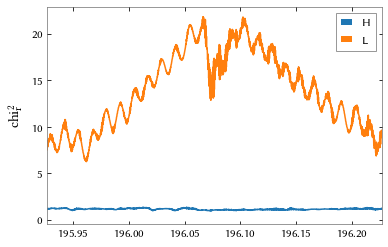

In [115]:
plot_check_chisq(data_raw, 196.07642, 10)

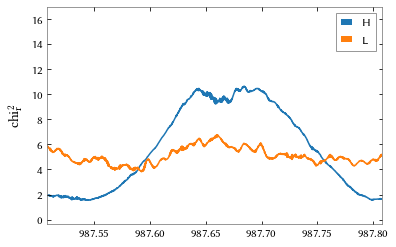

In [116]:
plot_check_chisq(data_raw, 987.6577, 10)

In [20]:
# Commented Table that summarizes the analysis
# Associated Q-transform plots are shown below

summary = QTable(names=['event_H',
                        'event_L',
                        'classification',
                        'time_H_approx',
                        'time_L_approx', 
                        'SNR_H_approx',
                        'SNR_L_approx',
                        'mass_H_approx',
                        'mass_L_approx'], 
                 dtype=[*['bool']*2, 'U20', *['float']*6])
N=9
tmp_event_H        = [False, False, *[True]*6, False]
tmp_event_L        = [True, True, False, *[True]*6]
tmp_classification = ['noise', 'blip', 'blip (rippled)', *['chirp']*3, 'chirp', 'chirp', 'noise']

time_H_approx      = [np.nan, np.nan, 987.6577, 1204.708, 1638.1577, 2483.9675, 2995.3396, 3319.2502, np.nan]
SNR_H_approx       = [np.nan, np.nan, 12.015228, 44.5408, 26.00237, 29.00907, 11.072669, 13.667905,  np.nan]
mass_H_approx      = [np.nan, np.nan, 50.0, 22.0, 16.0, 10.0, 32.0, 36.0, np.nan]
time_L_approx      = [10.027588, 196.07642, np.nan, 1204.7083, 1638.1553, 2483.9675, 2995.3386, 3319.251, 4089.9255]
SNR_L_approx       = [7.6929965, 17.513155, np.nan, 53.27839, 25.940258, 33.88981, 9.104351, 14.770378, 8.124456]
mass_L_approx      = [10.0, 44.0, np.nan, 22.0, 18.0, 10.0, 32.0, 34.0, 50.0]      


for k in range(N):
    summary.add_row([tmp_event_H[k],
                     tmp_event_L[k],
                     tmp_classification[k],
                     time_H_approx[k], time_L_approx[k],
                     SNR_H_approx[k], SNR_L_approx[k],
                     mass_H_approx[k], mass_L_approx[k]])
    
summary.write('./events_final.txt', format='ascii')

# Question 1 & 2 : Results

In [21]:
summary

<QTable length=9>
event_H event_L classification ... SNR_L_approx mass_H_approx mass_L_approx
  bool    bool      str20      ...   float32       float32       float32   
------- ------- -------------- ... ------------ ------------- -------------
  False    True          noise ...    7.6929965           nan          10.0
  False    True           blip ...    17.513155           nan          44.0
   True   False blip (rippled) ...          nan          50.0           nan
   True    True          chirp ...     53.27839          22.0          22.0
   True    True          chirp ...    25.940258          16.0          18.0
   True    True          chirp ...     33.88981          10.0          10.0
   True    True          chirp ...     9.104351          32.0          32.0
   True    True          chirp ...    14.770378          36.0          34.0
  False    True          noise ...     8.124456           nan          50.0

<ipython-input-5-b99b975b9904>:111: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[j].pcolormesh(t, f, p**0.5, vmin=1, vmax=6)


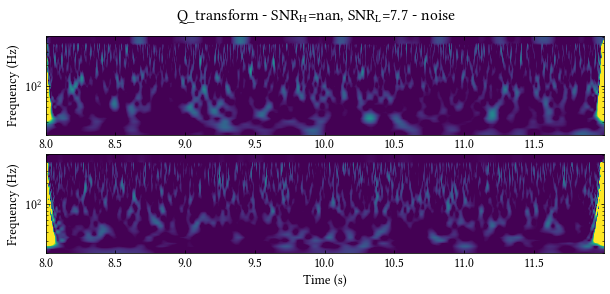

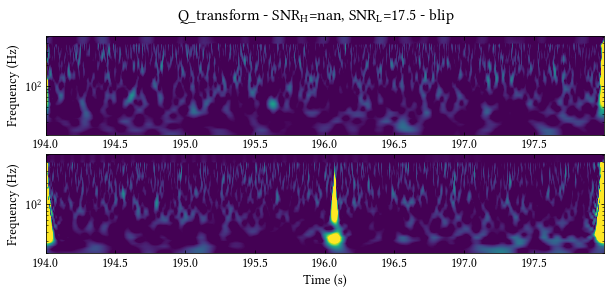

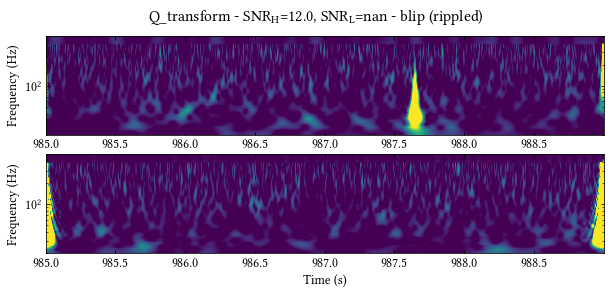

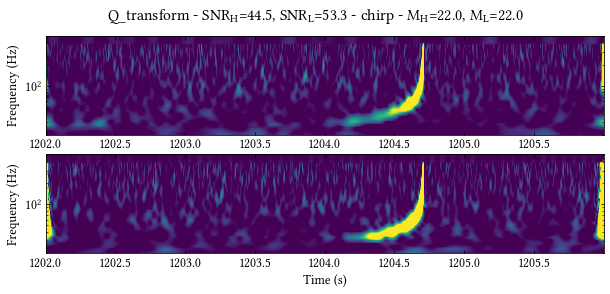

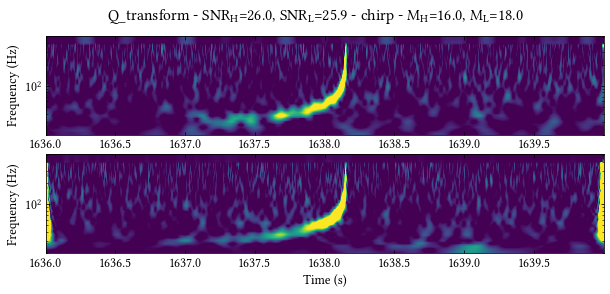

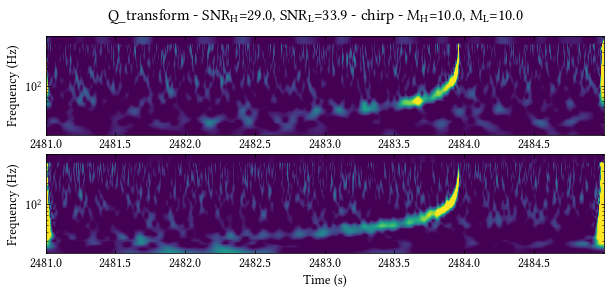

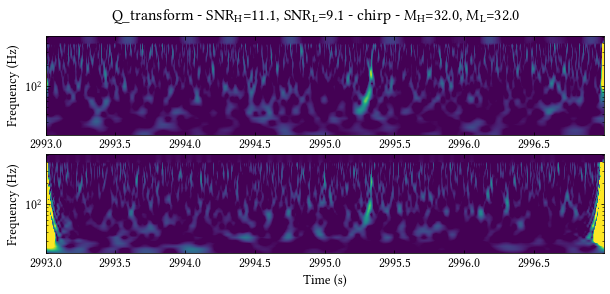

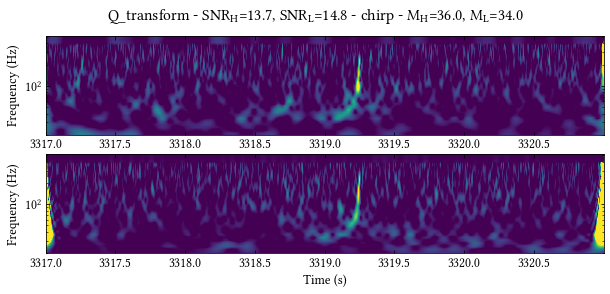

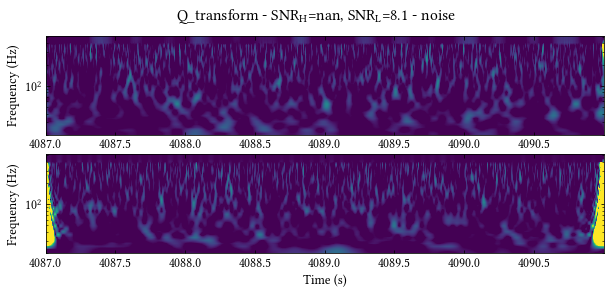

In [22]:
# Q transform plot

# time_s

for k in range(N):
    if  tmp_classification[k]=='chirp':
        figtitle =  r"Q_transform - SNR$_H$={:.1f}, SNR$_L$={:.1f} - {} - M$_H$={:.1f}, M$_L$={:.1f}".format(SNR_H_approx[k], 
                                                                                                    SNR_L_approx[k], 
                                                                                                    tmp_classification[k],
                                                                                                    mass_H_approx[k], 
                                                                                                    mass_L_approx[k])
    else:
        figtitle = r"Q_transform - SNR$_H$={:.1f}, SNR$_L$={:.1f} - {}".format(SNR_H_approx[k], SNR_L_approx[k], tmp_classification[k])

     
    plot_qtransform(data_raw, int(np.nanmean([time_H_approx[k],time_L_approx[k]])), 2, figtitle)

# Question 3
## Compute a more accurate estimation of the mass of the black holes using bilby library
We compute the distribution of the likelihood of the masses of the black holes by using the "dynesty" algorithm une the bilby library. If the waveform simulated with the mass parameters match

Dynesty is a bayesian algorithm, it needs a prior and a likelihood to work.

Unfortunately, for a reason we can't explain, the sampler algorithm take too much time to run, so we don't have the results.

In [120]:
# using bilby
%%capture
!pip install bilby
import bilby

UsageError: Line magic function `%%capture` not found.


In [94]:
sampling_rate=data_raw[0].sample_rate #needs to be high enough for the signals found in steps above
duration=10 #needs to be long enough for the signals found in steps above
start_time=1200 #needs to be set so that the segment defined by [start_time,start_time+duration] contains the signal

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1','L1']:
    ifo=bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel=ifo_name+':CHALLENGE3')
    interferometers.append(ifo)

23:54 bilby INFO    : Reading data from frame file challenge3.gwf
23:54 bilby INFO    : Successfully loaded H1:CHALLENGE3.
23:54 bilby INFO    : Reading data from frame file challenge3.gwf
23:55 bilby INFO    : Successfully loaded L1:CHALLENGE3.


In [95]:
# compute prior
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = bilby.core.prior.Gaussian(name='chirp_mass', mu=30.0, sigma=5.0)
prior['mass_ratio'] = 1.0
prior['phase'] = 0#bilby.core.prior.Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = 0#bilby.core.prior.Uniform(name="geocent_time", minimum=0, maximum=10)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066

In [96]:
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
# create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='SEOBNRv4_opt', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

23:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [97]:
# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=False, phase_marginalization=False, distance_marginalization=False)

In [ ]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="1204",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)